In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("/home/ubuntu/ARTrade/strategy/Demo/BTCUSDT_BINANCE_1m_2024_01_04.csv")
print(data)

            open_time     open     high      low    close   volume  \
0       1704067200000  42314.0  42335.8  42289.6  42331.9  289.641   
1       1704067260000  42331.9  42353.1  42331.8  42350.4  202.444   
2       1704067320000  42350.4  42370.8  42349.6  42360.2  271.521   
3       1704067380000  42360.1  42405.8  42360.1  42405.8  392.238   
4       1704067440000  42405.7  42437.2  42405.7  42437.1  568.366   
...               ...      ...      ...      ...      ...      ...   
174230  1714521000000  60877.5  60890.2  60810.1  60834.3  130.191   
174231  1714521060000  60834.3  60835.3  60776.5  60791.9  119.424   
174232  1714521120000  60792.0  60822.0  60790.8  60790.8   66.904   
174233  1714521180000  60790.8  60800.0  60759.3  60759.3   77.052   
174234  1714521240000  60759.3  60776.0  60721.1  60731.6  134.499   

        quote_volume  count  taker_buy_quote_volume  last_funding_rate  color  \
0       1.225616e+07   3310            7.414460e+06           0.000374      1 

In [3]:
df = pd.DataFrame()

df["Open"] = data["open"]
df["High"] = data["high"]
df["Low"] = data["low"]
df["Close"] = data["close"]
df["Volume"] = data["volume"]
df.index = data["open_time"]
df.index = pd.to_datetime(df.index.astype(int) / 1000, unit='s')

print(df)

                        Open     High      Low    Close   Volume
open_time                                                       
2024-01-01 00:00:00  42314.0  42335.8  42289.6  42331.9  289.641
2024-01-01 00:01:00  42331.9  42353.1  42331.8  42350.4  202.444
2024-01-01 00:02:00  42350.4  42370.8  42349.6  42360.2  271.521
2024-01-01 00:03:00  42360.1  42405.8  42360.1  42405.8  392.238
2024-01-01 00:04:00  42405.7  42437.2  42405.7  42437.1  568.366
...                      ...      ...      ...      ...      ...
2024-04-30 23:50:00  60877.5  60890.2  60810.1  60834.3  130.191
2024-04-30 23:51:00  60834.3  60835.3  60776.5  60791.9  119.424
2024-04-30 23:52:00  60792.0  60822.0  60790.8  60790.8   66.904
2024-04-30 23:53:00  60790.8  60800.0  60759.3  60759.3   77.052
2024-04-30 23:54:00  60759.3  60776.0  60721.1  60731.6  134.499

[174235 rows x 5 columns]


In [4]:

rsi = ta.rsi(df['Close'], length=14)
macd = ta.macd(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
kdj = ta.kdj(df["High"], df["Low"], df["Close"], length=14)

df['RSI'] = rsi
df[["MACDline", "MACDsignal", "MACDhist"]] = macd
df[["KDJ_K", "KDJ_D", "KDJ_J"]] = kdj

print(df)

                        Open     High      Low    Close   Volume        RSI  \
open_time                                                                     
2024-01-01 00:00:00  42314.0  42335.8  42289.6  42331.9  289.641        NaN   
2024-01-01 00:01:00  42331.9  42353.1  42331.8  42350.4  202.444        NaN   
2024-01-01 00:02:00  42350.4  42370.8  42349.6  42360.2  271.521        NaN   
2024-01-01 00:03:00  42360.1  42405.8  42360.1  42405.8  392.238        NaN   
2024-01-01 00:04:00  42405.7  42437.2  42405.7  42437.1  568.366        NaN   
...                      ...      ...      ...      ...      ...        ...   
2024-04-30 23:50:00  60877.5  60890.2  60810.1  60834.3  130.191  64.962340   
2024-04-30 23:51:00  60834.3  60835.3  60776.5  60791.9  119.424  59.928278   
2024-04-30 23:52:00  60792.0  60822.0  60790.8  60790.8   66.904  59.798811   
2024-04-30 23:53:00  60790.8  60800.0  60759.3  60759.3   77.052  56.063619   
2024-04-30 23:54:00  60759.3  60776.0  60721.1  6073

In [14]:
df['trade_point'] = 0

# 金叉
golden_cross_condition = (df['KDJ_K'] > df['KDJ_D']) & (df['KDJ_K'].shift(1) <= df['KDJ_D'].shift(1)) & (df['KDJ_K'] <= 20)
df.loc[golden_cross_condition, 'trade_point'] = 1
# 死叉
death_cross_condition = (df['KDJ_K'] < df['KDJ_D']) & (df['KDJ_K'].shift(1) >= df['KDJ_D'].shift(1)) & (df['KDJ_K'] >= 80)
df.loc[death_cross_condition, 'trade_point'] = -1



In [17]:
# 模拟回测

init = 100.0
fee = 0.001
# 当前是否持仓
isOrder: int = 0
# 开仓价格(kline的close)
orderPrice = 0.0
# 开仓净值
order_net_value = init
# 止损
stop_loss = 0.1


df["net_value"] = init

for index, row in df.iterrows():
    # 开空 / 平多
    if row["trade_point"] < -0.5 and isOrder > -1:
        if orderPrice > 0:
            df.loc[index, "net_value"] = order_net_value * (1 + ((row["Close"] - orderPrice) / orderPrice)) * (1 - fee)
        isOrder = -1
        orderPrice = row["Close"]
        order_net_value = df.loc[index, "net_value"]
        continue

    # 开多 / 平空
    if row["trade_point"] > 0.5 and isOrder < 1:
        if orderPrice > 0:
            df.loc[index, "net_value"] = order_net_value * (1 - ((row["Close"] - orderPrice) / orderPrice)) * (1 - fee)
        isOrder = 1
        orderPrice = row["Close"]
        order_net_value = df.loc[index, "net_value"]
        continue

    # 更新未实现盈利
    if orderPrice > 0:
        if isOrder == 1:
            df.loc[index, "net_value"] = order_net_value * (1 + ((row["Close"] - orderPrice) / orderPrice)) * (1 - fee)

            if -1 * (row["Close"] - orderPrice) / orderPrice >= stop_loss:
                isOrder = 0
                orderPrice = 0.0

        if isOrder == -1:
            df.loc[index, "net_value"] = order_net_value * (1 - ((row["Close"] - orderPrice) / orderPrice)) * (1 - fee)
            
            if (row["Close"] - orderPrice) / orderPrice >= stop_loss:
                isOrder = 0
                orderPrice = 0.0


print(df)



                        Open     High      Low    Close   Volume        RSI  \
Date                                                                          
2024-01-01 00:00:00  42314.0  42335.8  42289.6  42331.9  289.641        NaN   
2024-01-01 00:01:00  42331.9  42353.1  42331.8  42350.4  202.444        NaN   
2024-01-01 00:02:00  42350.4  42370.8  42349.6  42360.2  271.521        NaN   
2024-01-01 00:03:00  42360.1  42405.8  42360.1  42405.8  392.238        NaN   
2024-01-01 00:04:00  42405.7  42437.2  42405.7  42437.1  568.366        NaN   
...                      ...      ...      ...      ...      ...        ...   
2024-04-30 23:50:00  60877.5  60890.2  60810.1  60834.3  130.191  64.962340   
2024-04-30 23:51:00  60834.3  60835.3  60776.5  60791.9  119.424  59.928278   
2024-04-30 23:52:00  60792.0  60822.0  60790.8  60790.8   66.904  59.798811   
2024-04-30 23:53:00  60790.8  60800.0  60759.3  60759.3   77.052  56.063619   
2024-04-30 23:54:00  60759.3  60776.0  60721.1  6073

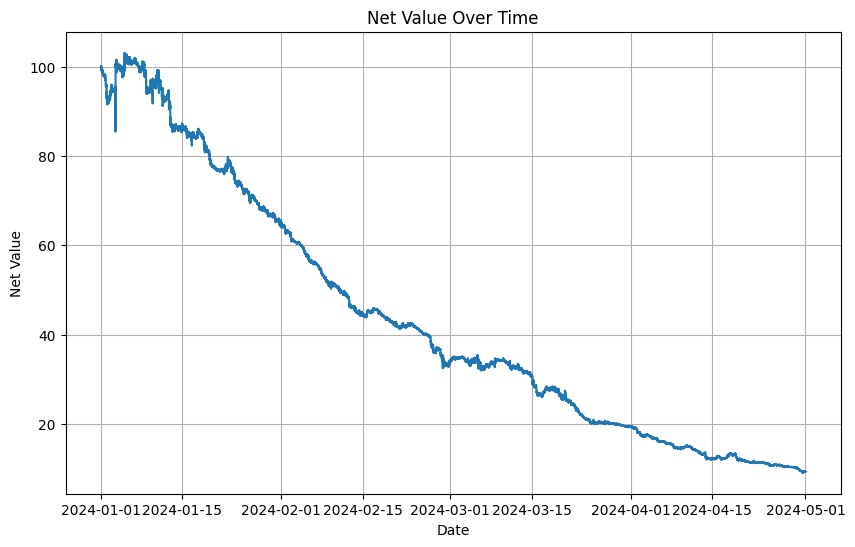

In [18]:
df["Date"] = pd.to_datetime(df.index)
df.set_index("Date", inplace=True)

# 绘制折线图
plt.figure(figsize=(10, 6))  # 设置图像大小（可选）
plt.plot(df.index.to_numpy(), df['net_value'].to_numpy())  # 绘制折线，'o'表示在每个数据点上显示一个圆圈

# 设置标题和轴标签（可选）
plt.title('Net Value Over Time')
plt.xlabel('Date')
plt.ylabel('Net Value')

# 显示网格（可选）
plt.grid(True)

# 显示图像
plt.show()

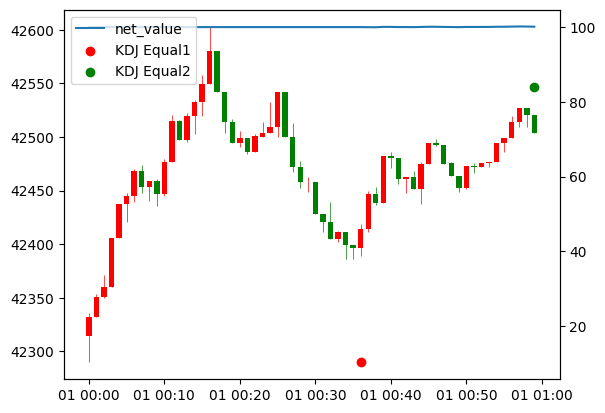

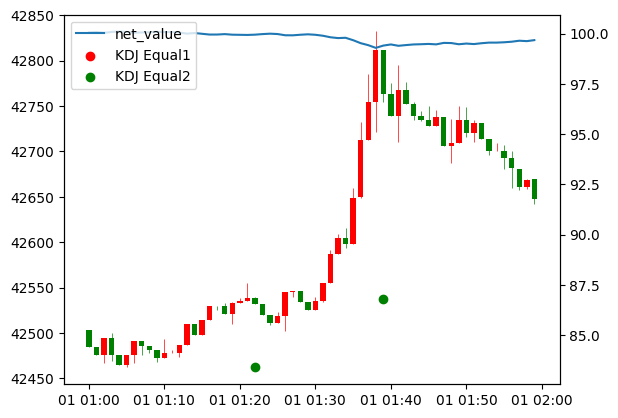

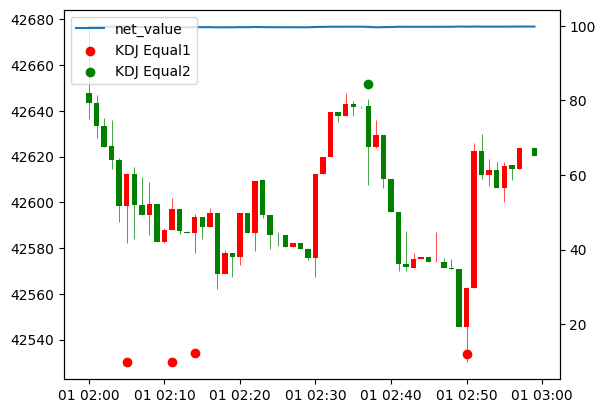

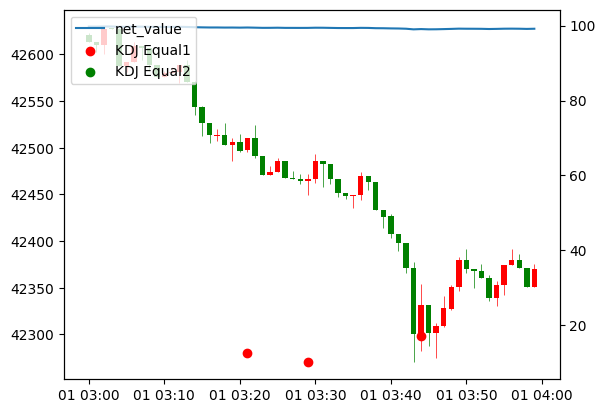

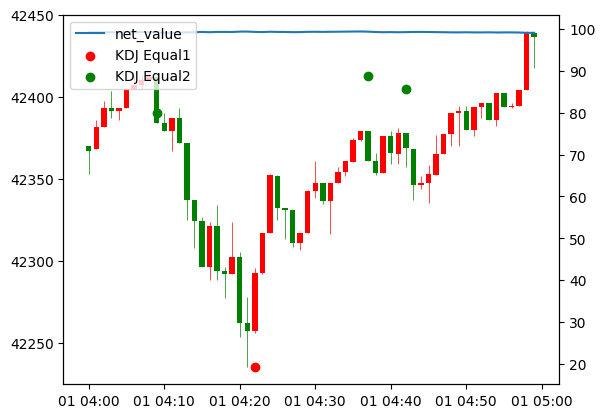

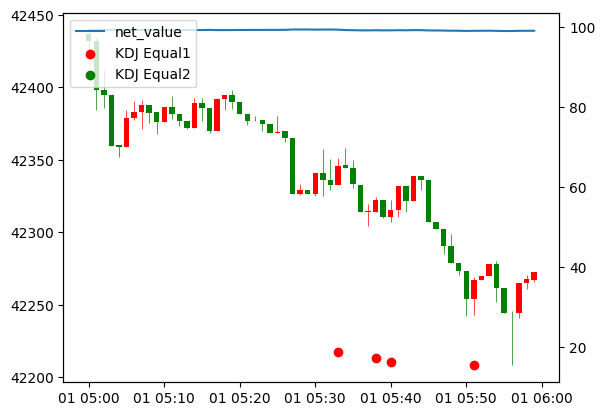

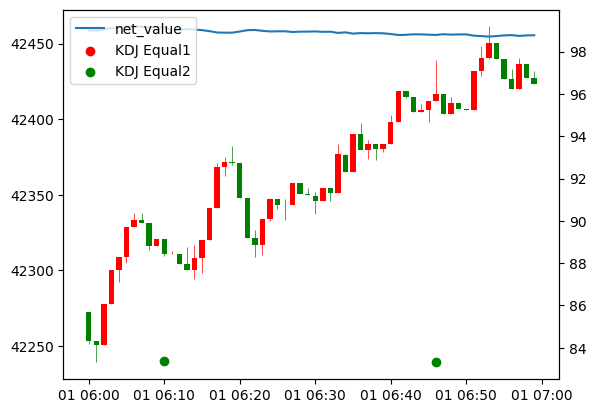

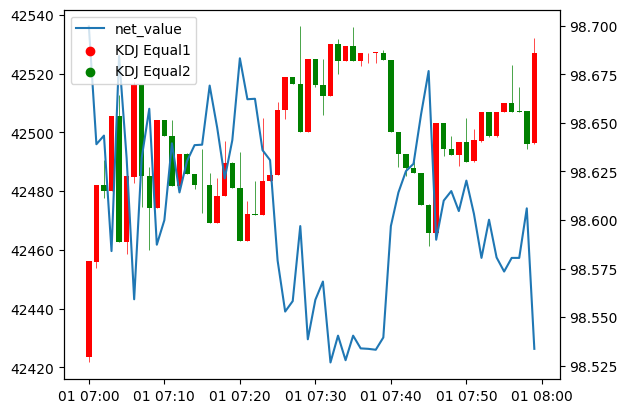

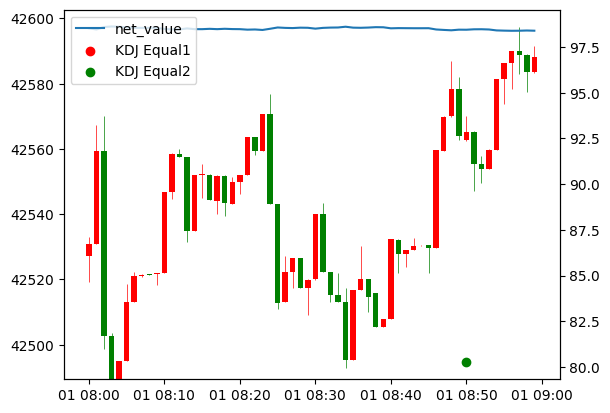

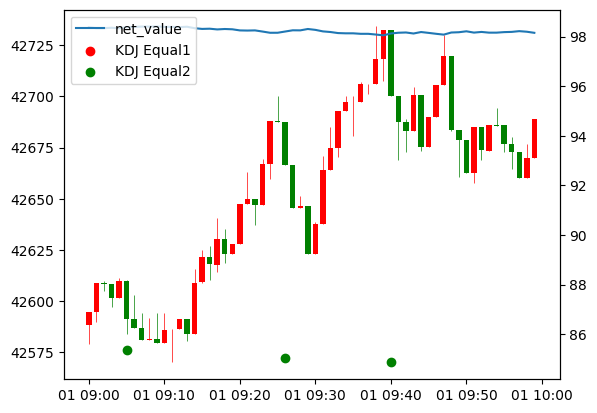

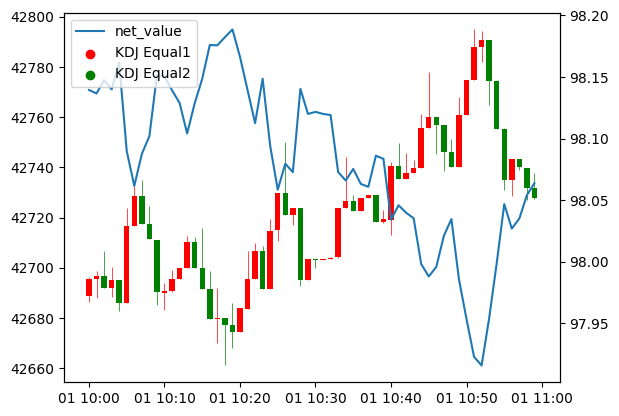

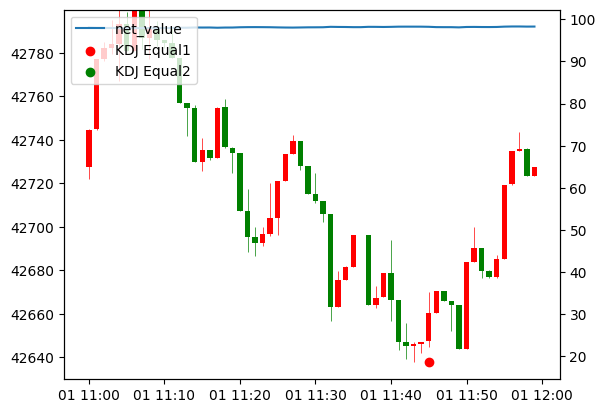

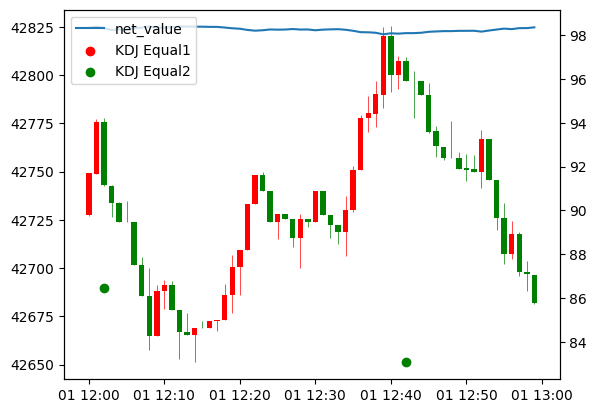

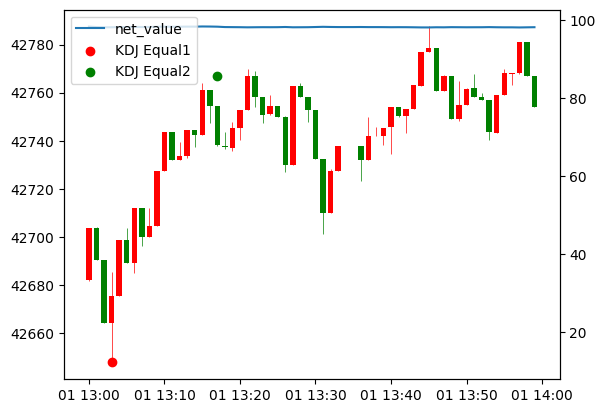

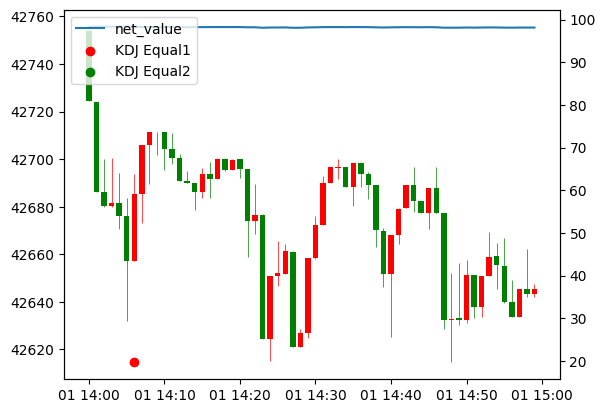

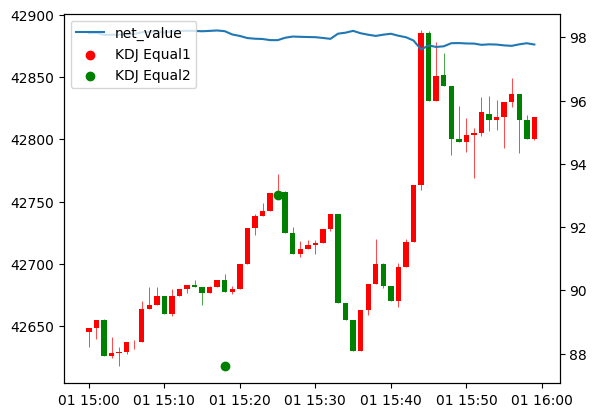

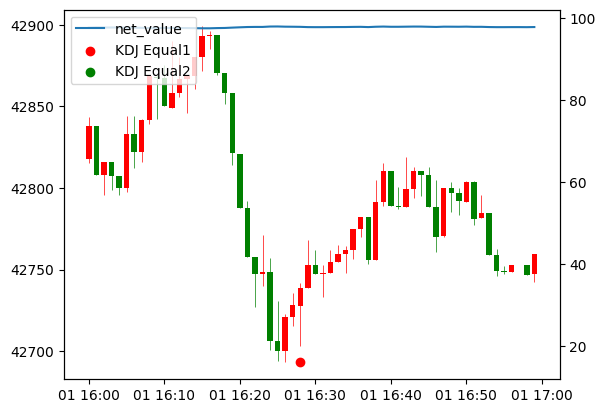

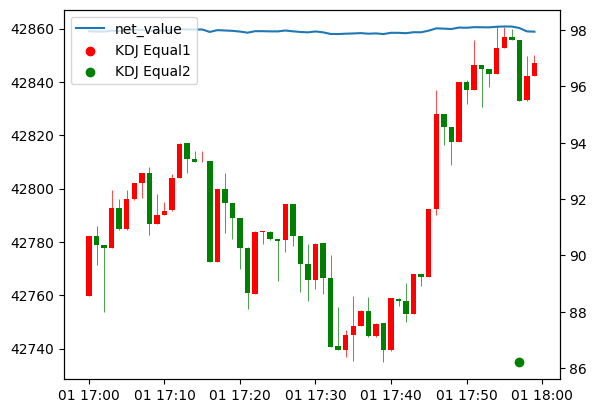

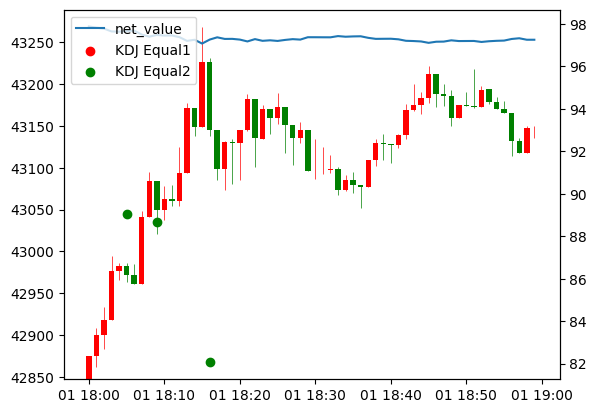

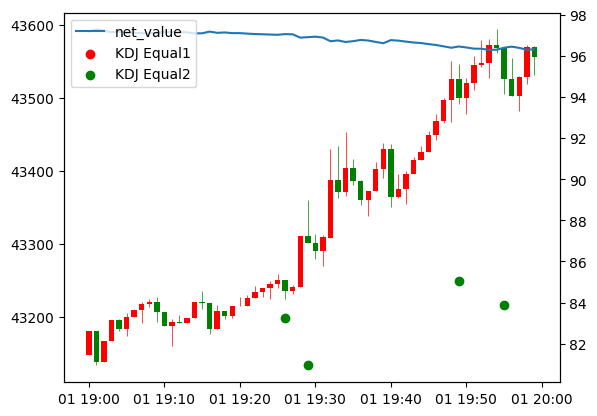

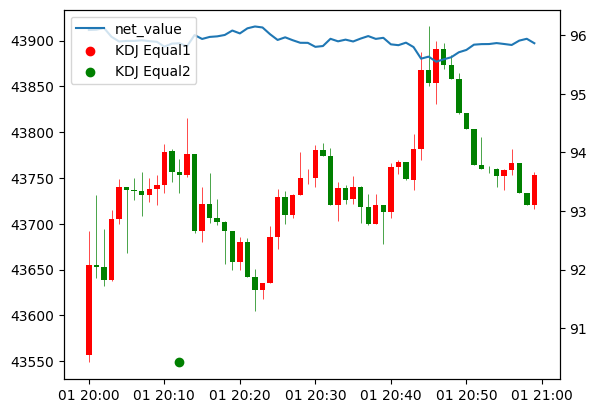

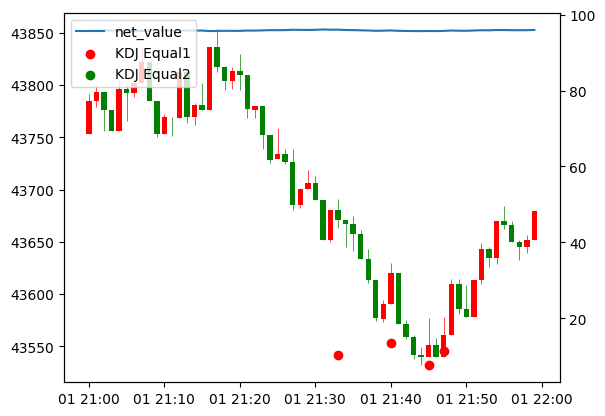

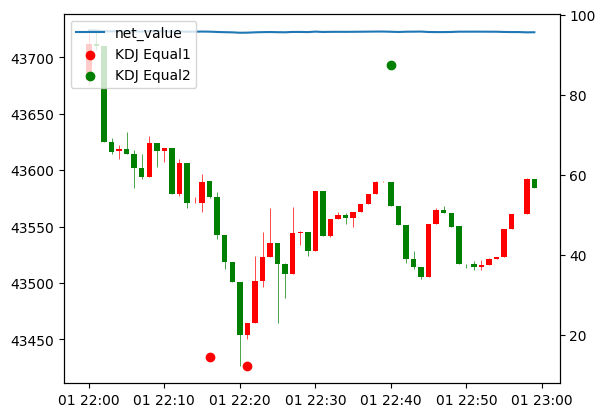

KeyboardInterrupt: Interrupted by user

In [20]:


UpColor = "red"
DownColor = "green"
ColorType = True

if ColorType == False:
    UpColor, DownColor = DownColor, UpColor

df["Date"] = pd.to_datetime(df.index)
df.set_index("Date", inplace=True)

for name, group in df.groupby(pd.Grouper(freq='h')):
    fig, ax1 = plt.subplots()
    colors = [UpColor if open <= close else DownColor for open, close in zip(group["Open"], group["Close"])]
    # 绘制Kline
    ax1.bar(group.index.to_numpy(), group["Close"] - group["Open"], tick_label='',width=0.0005, bottom=group["Open"] ,color = colors)
    ax1.vlines(group.index.to_numpy(), group["Low"], group["High"], colors=colors, lw=0.5)

    # 绘制指标
    ax2 = ax1.twinx()

    # ax2.plot(group.index.to_numpy(), group["KDJ_K"].fillna(0).to_numpy(), label='KDJ_K')
    # ax2.plot(group.index.to_numpy(), group["KDJ_D"].fillna(0).to_numpy(), label='KDJ_D')
    # ax2.plot(group.index.to_numpy(), group["KDJ_J"].fillna(0).to_numpy(), label='KDJ_J')
    ax2.plot(group.index.to_numpy(), group["net_value"].fillna(0).to_numpy(), label='net_value')



    # 找出金叉点（K线上穿D线）
    golden_cross_points = group[(group['KDJ_K'] > group['KDJ_D']) & (group['KDJ_K'].shift(1) <= group['KDJ_D'].shift(1)) & (group['KDJ_K'] <= 20)].index

    # 找出死叉点（K线下穿D线）
    death_cross_points = group[(group['KDJ_K'] < group['KDJ_D']) & (group['KDJ_K'].shift(1) >= group['KDJ_D'].shift(1)) & (group['KDJ_K'] >= 80)].index
    # # 使用scatter函数在相等点上绘制红点
    ax2.scatter(golden_cross_points, group.loc[golden_cross_points, "KDJ_K"], color='red', label='KDJ Equal1')
    ax2.scatter(death_cross_points, group.loc[death_cross_points, "KDJ_K"], color='green', label='KDJ Equal2')

    ax2.legend(loc='upper left')

    # 设置plt
    plt.show()
    input()